### Importing necessary libraries

In [1]:
import os
import random
import shutil
import time
import warnings
from pathlib import Path
from collections import Counter, defaultdict

# Data processing
import numpy as np
import pandas as pd
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.multiprocessing as mp
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

# Torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as torchmodels
from torchvision.utils import make_grid

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

### Dataset Class

In [2]:
class WikiArtCombinedDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Dataset for the combined WikiArt dataset with artist, genre, and style labels.
        
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        # Keep track of valid indices after filtering out corrupted files
        self.valid_indices = self._validate_files()
        
    def _validate_files(self):
        """Validate all files in the dataset and return list of valid indices.""" ## This was added because some files in the dataset were found to be corrupted
        valid_indices = []
        for idx in range(len(self.annotations)):
            # Get file path from the 'file' column
            img_path = self.annotations.iloc[idx, 0]
            
            # Extract the style/category from the path (first part before the slash)
            category = img_path.split('/')[0]
            
            # Construct the full path based on your directory structure
            # Assuming the structure is root_dir/category/category/image_filename
            full_path = os.path.join(self.root_dir, category, category, os.path.basename(img_path))
            
            if os.path.exists(full_path):
                try:
                    # Try to open the image to check if it's valid
                    with Image.open(full_path) as img:
                        img.verify()  # Verify the image
                    valid_indices.append(idx)
                except (IOError, OSError) as e:
                    print(f"Corrupted image at index {idx}, path: {full_path}, Error: {e}")
            else:
                print(f"Missing image at index {idx}, path: {full_path}")
                
        print(f"Found {len(valid_indices)} valid images out of {len(self.annotations)}")
        return valid_indices
        
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Map the clean index to the original dataset index
        original_idx = self.valid_indices[idx]
        
        # Get the file path and labels from CSV
        img_path = self.annotations.iloc[original_idx, 0]  # First column (file)
        artist_label = self.annotations.iloc[original_idx, 1]  # Second column (artist)
        genre_label = self.annotations.iloc[original_idx, 2]   # Third column (genre)
        style_label = self.annotations.iloc[original_idx, 3]   # Fourth column (style)
        
        # Extract the category from the path (assuming format like "Category/image.jpg")
        category = img_path.split('/')[0]
        
        # Construct the full path with the correct structure
        full_path = os.path.join(self.root_dir, category, category, os.path.basename(img_path))
        
        try:
            # Load image
            image = Image.open(full_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
                
            # Return image and all three labels
            return image, (artist_label, genre_label, style_label)
        except (IOError, OSError) as e:
            # This should not happen since we've validated the files,
            # but just in case there's a race condition or file is modified
            print(f"Error loading previously validated image {full_path}: {e}")
            # Return a placeholder image
            placeholder = torch.zeros(3, 224, 224) if self.transform else Image.new('RGB', (224, 224), color='black')
            return placeholder, (artist_label, genre_label, style_label)

In [3]:
# Create the full dataset with the combined CSV file
full_dataset = WikiArtCombinedDataset(
    csv_file='/kaggle/input/wiki-art-comined/wikiartcombined_remapped.csv',
    root_dir='/kaggle/input/lesssgooooowikiart',
    transform=None  # We'll apply transforms after splitting
)

Found 11272 valid images out of 11272


In [4]:
# Enhanced data augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.1),  # Color jittering (important for artwork)
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Random translation and scaling
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Perspective changes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.25)  # Random erasing after normalization
])


# Define transforms for testing and validation
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),             # Resize the image to 256,256         
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [5]:
# Split the dataset into train, validation, and test sets (80:10:10)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Create the splits with fixed seed for reproducibility
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Create dataset wrappers to apply the appropriate transforms
class TransformWrapper(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, labels = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, labels

# Apply the transforms to each split
train_dataset_transformed = TransformWrapper(train_dataset, train_transforms)
val_dataset_transformed = TransformWrapper(val_dataset, test_transforms)  # Using test transforms for validation
test_dataset_transformed = TransformWrapper(test_dataset, test_transforms)

# Create a custom collate function to handle any issues 
def collate_fn(batch):
    # Filter out None values if any
    batch = list(filter(lambda x: x is not None and not (isinstance(x[0], torch.Tensor) and x[0].sum() == 0), batch))
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

# Create dataloaders
batch_size = 32

train_loader = DataLoader(
    train_dataset_transformed,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset_transformed,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset_transformed,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

### Model code

In [6]:
# ============================= SE Layer =============================

# https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# ============================= ECA Mechansim =============================
class eca_layer(nn.Module):
    """Constructs a ECA module.
    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
        source: https://github.com/BangguWu/ECANet
    """
    def __init__(self, channel, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: input features with shape [b, c, h, w]
        b, c, h, w = x.size()

        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)

# ============================= CBAM Module =============================
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None
        
    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
        self.pool_types = pool_types
        
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool)
            elif pool_type == 'max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool)
            elif pool_type == 'lp':
                lp_pool = F.lp_pool2d(x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(lp_pool)
            elif pool_type == 'lse':
                # LSE pool
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp(lse_pool)
                
            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw
                
        scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
        
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
            
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [7]:
# ============================= ConvLSTM Cell =============================
class ConvLSTMCell_layer(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=(3, 3), bias=False):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """
        super(ConvLSTMCell_layer, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        # cur_state is a tuple
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)  # Input gate
        f = torch.sigmoid(cc_f)  # Forget gate
        o = torch.sigmoid(cc_o)  # Output gate
        g = torch.tanh(cc_g)     # Cell gate

        c_next = f * c_cur + i * g  # Update cell state
        h_next = o * torch.tanh(c_next)  # Update hidden state

        return h_next, c_next

In [8]:
# ============================= ResNet Helper Functions =============================
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [9]:
# ============================= RLA Bottleneck Block =============================

class RLA_Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, 
                 rla_channel=32, attention_type=None, attention_param=None, 
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        super(RLA_Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        # `planes * base_width / 64 * cardinality`
        width = int(planes * (base_width / 64.)) * groups
        
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes + rla_channel, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
        self.averagePooling = None
        if downsample is not None and stride != 1:
            self.averagePooling = nn.AvgPool2d((2, 2), stride=(2, 2))
        
        # Initialize attention module based on specified type
        self.attention_module = None
        channels = planes * self.expansion
        
        if attention_type == 'SE':
            reduction = 16 if attention_param is None else attention_param
            self.attention_module = SELayer(channels, reduction)
        elif attention_type == 'ECA':
            k_size = 3 if attention_param is None else attention_param
            self.attention_module = eca_layer(channels, k_size)
        elif attention_type == 'CBAM':
            reduction = 16 if attention_param is None else attention_param
            self.attention_module = CBAM(channels, reduction)

    def forward(self, x, h, c):
        identity = x
        
        x = torch.cat((x, h), dim=1)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        
        # Apply attention module if specified
        if self.attention_module is not None:
            out = self.attention_module(out)
        
        y = out
        
        if self.downsample is not None:
            identity = self.downsample(identity)
        if self.averagePooling is not None:
            h = self.averagePooling(h)
            c = self.averagePooling(c)
        
        out += identity
        out = self.relu(out)

        return out, y, h, c

In [10]:
# ============================= RLAlstm_ResNet Network =============================
class RLAlstm_ResNet(nn.Module):
    
    def __init__(self, block, layers,artist_classes=1000,genre_classes=1000,style_classes=1000,
                 rla_channel=32, attention_type=None, attention_params=None,
                 zero_init_last_bn=True,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        """
        Initialize RLAlstm_ResNet model with flexible attention mechanisms.
        
        Parameters:
        ----------
        block : nn.Module
            The block module to use (e.g., RLA_Bottleneck)
        layers : list
            Number of blocks in each layer
        num_classes : int
            Number of output classes
        rla_channel : int
            Number of filters in RLA
        attention_type : str or None
            Type of attention to use: 'SE', 'ECA', 'CBAM', or None
        attention_params : list or None
            Parameters for attention modules for each stage
            For SE: reduction ratios
            For ECA: kernel sizes
            For CBAM: reduction ratios
        """
        super(RLAlstm_ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        
        # Default attention parameters if None provided
        if attention_params is None and attention_type is not None:
            if attention_type == 'SE':
                attention_params = [16, 16, 16, 16]  # Default reduction ratios
            elif attention_type == 'ECA':
                attention_params = [3, 5, 7, 9]  # Default kernel sizes
            elif attention_type == 'CBAM':
                attention_params = [16, 16, 16, 16]  # Default reduction ratios
        
        self.rla_channel = rla_channel
        self.flops = False
        self.attention_type = attention_type
        
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        conv_outs = [None] * 4
        recurrent_convs = [None] * 4
        stages = [None] * 4
        stage_bns = [None] * 4

        # Create the four stages of the network with appropriate attention mechanisms
        # For each stage, we use the corresponding attention parameter if provided
        stages[0], stage_bns[0], conv_outs[0], recurrent_convs[0] = self._make_layer(
            block, 64, layers[0], 
            rla_channel=rla_channel, 
            attention_type=attention_type, 
            attention_param=None if attention_params is None else attention_params[0]
        )
        
        stages[1], stage_bns[1], conv_outs[1], recurrent_convs[1] = self._make_layer(
            block, 128, layers[1], 
            rla_channel=rla_channel, 
            attention_type=attention_type, 
            attention_param=None if attention_params is None else attention_params[1],
            stride=2, 
            dilate=replace_stride_with_dilation[0]
        )
        
        stages[2], stage_bns[2], conv_outs[2], recurrent_convs[2] = self._make_layer(
            block, 256, layers[2], 
            rla_channel=rla_channel, 
            attention_type=attention_type, 
            attention_param=None if attention_params is None else attention_params[2],
            stride=2, 
            dilate=replace_stride_with_dilation[1]
        )
        
        stages[3], stage_bns[3], conv_outs[3], recurrent_convs[3] = self._make_layer(
            block, 512, layers[3], 
            rla_channel=rla_channel, 
            attention_type=attention_type, 
            attention_param=None if attention_params is None else attention_params[3],
            stride=2, 
            dilate=replace_stride_with_dilation[2]
        )
        
        self.conv_outs = nn.ModuleList(conv_outs)
        self.recurrent_convs = nn.ModuleList(recurrent_convs)
        self.stages = nn.ModuleList(stages)
        self.stage_bns = nn.ModuleList(stage_bns)
        
        self.tanh = nn.Tanh()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512 * block.expansion + rla_channel, artist_classes)
        self.fc2 = nn.Linear(512 * block.expansion + rla_channel, genre_classes)
        self.fc3 = nn.Linear(512 * block.expansion + rla_channel, style_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch
        if zero_init_last_bn:
            for m in self.modules():
                if isinstance(m, RLA_Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                    
    def _make_layer(self, block, planes, blocks, 
                    rla_channel, attention_type, attention_param, stride=1, dilate=False):
        
        conv_out = conv1x1(planes * block.expansion, rla_channel)
        recurrent_convlstm = ConvLSTMCell_layer(rla_channel, rla_channel, (3, 3))
        
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, 
                            rla_channel=rla_channel, 
                            attention_type=attention_type, 
                            attention_param=attention_param,
                            groups=self.groups,
                            base_width=self.base_width, 
                            dilation=previous_dilation, 
                            norm_layer=norm_layer))
        
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, 
                                rla_channel=rla_channel, 
                                attention_type=attention_type, 
                                attention_param=attention_param,
                                groups=self.groups,
                                base_width=self.base_width, 
                                dilation=self.dilation,
                                norm_layer=norm_layer))

        bns = [norm_layer(rla_channel) for _ in range(blocks)]

        return nn.ModuleList(layers), nn.ModuleList(bns), conv_out, recurrent_convlstm
    
    def _forward_impl(self, x):
        # Initial feature extraction
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Initialize hidden states
        batch, _, height, width = x.size()
        if self.flops:  # For computing FLOPs and params
            h = torch.zeros(batch, self.rla_channel, height, width)
            c = torch.zeros(batch, self.rla_channel, height, width)
        else:
            h = torch.zeros(batch, self.rla_channel, height, width, device='cuda')
            c = torch.zeros(batch, self.rla_channel, height, width, device='cuda')

        # Process through stages with RLA
        for layers, bns, conv_out, recurrent_convlstm in zip(self.stages, self.stage_bns, self.conv_outs, self.recurrent_convs):    
            for layer, bn in zip(layers, bns):
                # Forward through RLA bottleneck block
                x, y, h, c = layer(x, h, c)
                
                # RLA module updates
                y_out = conv_out(y)
                y_out = bn(y_out)
                y_out = self.tanh(y_out)
                
                # Update hidden states using ConvLSTM
                h, c = recurrent_convlstm(y_out, (h, c))
        
        # Concatenate final feature maps with hidden state
        x = torch.cat((x, h), dim=1)
        
        # Global average pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        ## Fully connected layers removed for obtaining embeddings of image
        return x

    def forward(self, x):
        return self._forward_impl(x)  

In [11]:
def rlalstm_resnet50(artist_classes=1000,genre_classes=1000,style_classes=1000, rla_channel=32, attention_type=None, attention_params=None):
    """
    Constructs a RLAlstm_ResNet-50 model with flexible attention mechanisms.
    
    Parameters:
    -----------
    num_classes : int
        Number of output classes
    rla_channel : int
        Number of channels in RLA module
    attention_type : str or None
        Type of attention to use: 'SE', 'ECA', 'CBAM', or None
    attention_params : list or None
        Parameters for attention modules for each stage
        - For SE: reduction ratios (default: [16, 16, 16, 16])
        - For ECA: kernel sizes (default: [3, 5, 7, 9])
        - For CBAM: reduction ratios (default: [16, 16, 16, 16])
    
    Returns:
    --------
    model : RLAlstm_ResNet
        The initialized model
    """
    print(f"Constructing rlalstm_resnet50 with {attention_type} attention...")
    model = RLAlstm_ResNet(
        RLA_Bottleneck, 
        [3, 4, 6, 3], 
        artist_classes=artist_classes,
        genre_classes=genre_classes,
        style_classes=style_classes,
        rla_channel=rla_channel,
        attention_type=attention_type,
        attention_params=attention_params
    )
    return model

In [12]:
model= rlalstm_resnet50(
    artist_classes=23,
    genre_classes=10,
    style_classes=16,
    rla_channel=32,
    attention_type='SE',
    attention_params=[16, 16, 16, 16]  # Reduction ratios for each stage
)

Constructing rlalstm_resnet50 with SE attention...


In [13]:
model.to(device)

RLAlstm_ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv_outs): ModuleList(
    (0): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(512, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Conv2d(1024, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): Conv2d(2048, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (recurrent_convs): ModuleList(
    (0-3): 4 x ConvLSTMCell_layer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (stages): ModuleList(
    (0): ModuleList(
      (0): RLA_Bottleneck(
        (conv1): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momen

### Loading model weights

In [14]:
weight = torch.load("/kaggle/input/best-checkpoint/model_best.pt")
model.load_state_dict(weight)

<ipython-input-14-8ea65b357390>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load("/kaggle/input/best-checkpoint/model_best.pt")


<All keys matched successfully>

### Setting up parameters for outlier detection

In [15]:
num_artist_classes=23 
num_genre_classes=10
num_style_classes=16
contamination=0.05

# Example of human-readable label maps
label_maps = {
    'artist': {
        0: "Albrecht_Durer",
        1: "Boris_Kustodiev",
        2: "Camille_Pissarro", 
        3: "Childe_Hassam",
        4: "Claude_Monet",
        5: "Edgar_Degas",
        6: "Eugene_Boudin",
        7: "Gustave_Dore",
        8: "Ilya_Repin",
        9: "Ivan_Aivazovsky",
        10: "Ivan_Shishkin",
        11: "John_Singer_Sargent",
        12: "Marc_Chagall",
        13: "Martiros_Saryan",
        14: "Nicholas_Roerich",
        15: "Pablo_Picasso",
        16: "Paul_Cezanne",
        17: "Pierre_Auguste_Renoir",
        18: "Pyotr_Konchalovsky",
        19: "Raphael_Kirchner",
        20: "Rembrandt",
        21: "Salvador_Dali",
        22: "Vincent_van_Gogh"
    },
    'genre': {
        0: "abstract_painting",
        1: "cityscape",
        2: "genre_painting",
        3: "illustration",
        4: "landscape",
        5: "nude_painting",
        6: "portrait",
        7: "religious_painting",
        8: "sketch_and_study",
        9: "still_life"
    },

    'style': {
        0: "Abstract_Expressionism",
        1: "Analytical_Cubism",
        2: "Art_Nouveau",
        3: "Baroque",
        4: "Cubism",
        5: "Expressionism",
        6: "Fauvism",
        7: "Impressionism",
        8: "Naive_Art_Primitivism",
        9: "Northern_Renaissance",
        10: "Pointillism",
        11: "Post_Impressionism",
        12: "Realism",
        13: "Romanticism",
        14: "Symbolism",
        15: "Synthetic_Cubism"
    }
}

In [16]:
# 1. Collecting embedding for all three attributes 
def collect_data(model, test_loader, device):
    """Collect embeddings and all three types of labels from the test data"""
    embeddings = []
    artist_labels = []
    genre_labels = []
    style_labels = []
    
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            artist_target, genre_target, style_target = targets
            
            # Get the embedding from the model
            embedding = model(images)
            
            # Store embeddings and all three types of labels
            embeddings.append(embedding.cpu().numpy())
            artist_labels.append(artist_target.cpu().numpy())
            genre_labels.append(genre_target.cpu().numpy())
            style_labels.append(style_target.cpu().numpy())
    
    # Concatenate all batches
    X = np.concatenate(embeddings, axis=0)
    artist_labels = np.concatenate(artist_labels, axis=0)
    genre_labels = np.concatenate(genre_labels, axis=0)
    style_labels = np.concatenate(style_labels, axis=0)
    
    return X, artist_labels, genre_labels, style_labels

In [17]:
# Collecting embeddings of images from model and their corresponding ground truth labels

X, artist_labels, genre_labels, style_labels = collect_data(model, test_loader, device)

In [18]:
# 2. Perform clustering for each attribute type separately
def perform_attribute_specific_clustering(X, artist_labels, genre_labels, style_labels, 
                                         num_artist_classes=23, num_genre_classes=10, num_style_classes=16):
    """
    Perform separate clustering for each attribute type with specified class counts
    
    Parameters:
    -----------
    X : numpy array
        The embedding vectors
    artist_labels, genre_labels, style_labels : numpy array
        The ground truth labels
    num_artist_classes, num_genre_classes, num_style_classes : int
        The number of known classes for each attribute
        
    Returns:
    --------
    clustering_results : dict
        Dictionary containing the clustering results for each attribute
    """
    clustering_results = {}
    
    # 1. Artist clustering (k=23)
    print(f"Performing clustering for artists (k={num_artist_classes})...")
    artist_kmeans = KMeans(n_clusters=num_artist_classes, random_state=42, n_init=10)
    artist_clusters = artist_kmeans.fit_predict(X)
    artist_centers = artist_kmeans.cluster_centers_
    
    # Evaluate artist clustering
    if len(np.unique(artist_labels)) > 1:  # Only calculate if we have multiple classes
        artist_silhouette = silhouette_score(X, artist_clusters)
        print(f"Artist clustering silhouette score: {artist_silhouette:.4f}")
    else:
        artist_silhouette = 0
        print("Only one artist class present, skipping silhouette score")
    
    # 2. Genre clustering (k=10)
    print(f"Performing clustering for genres (k={num_genre_classes})...")
    genre_kmeans = KMeans(n_clusters=num_genre_classes, random_state=42, n_init=10)
    genre_clusters = genre_kmeans.fit_predict(X)
    genre_centers = genre_kmeans.cluster_centers_
    
    # Evaluate genre clustering
    if len(np.unique(genre_labels)) > 1:
        genre_silhouette = silhouette_score(X, genre_clusters)
        print(f"Genre clustering silhouette score: {genre_silhouette:.4f}")
    else:
        genre_silhouette = 0
        print("Only one genre class present, skipping silhouette score")
    
    # 3. Style clustering (k=16)
    print(f"Performing clustering for styles (k={num_style_classes})...")
    style_kmeans = KMeans(n_clusters=num_style_classes, random_state=42, n_init=10)
    style_clusters = style_kmeans.fit_predict(X)
    style_centers = style_kmeans.cluster_centers_
    
    # Evaluate style clustering
    if len(np.unique(style_labels)) > 1:
        style_silhouette = silhouette_score(X, style_clusters)
        print(f"Style clustering silhouette score: {style_silhouette:.4f}")
    else:
        style_silhouette = 0
        print("Only one style class present, skipping silhouette score")
    
    # Store results
    clustering_results['artist'] = {
        'clusters': artist_clusters,
        'centers': artist_centers,
        'silhouette': artist_silhouette
    }
    
    clustering_results['genre'] = {
        'clusters': genre_clusters,
        'centers': genre_centers,
        'silhouette': genre_silhouette
    }
    
    clustering_results['style'] = {
        'clusters': style_clusters,
        'centers': style_centers,
        'silhouette': style_silhouette
    }
    
    return clustering_results

In [19]:
clustering_results = perform_attribute_specific_clustering(
    X, artist_labels, genre_labels, style_labels,
    num_artist_classes=num_artist_classes,
    num_genre_classes=num_genre_classes,
    num_style_classes=num_style_classes
)

Performing clustering for artists (k=23)...
Artist clustering silhouette score: 0.1366
Performing clustering for genres (k=10)...
Genre clustering silhouette score: 0.1178
Performing clustering for styles (k=16)...
Style clustering silhouette score: 0.1288


In [20]:
# 3. Generate attribute confusion matrices in clustering
def generate_confusion_matrices(clustering_results, artist_labels, genre_labels, style_labels, label_maps=None):
    """
    Generate and visualize confusion matrices for each attribute
    
    Parameters:
    -----------
    clustering_results : dict
        Dictionary containing the clustering results for each attribute
    artist_labels, genre_labels, style_labels : numpy array
        The ground truth labels
    label_maps : dict or None
        Optional dictionary mapping from label indices to human-readable names
    """
    attribute_types = ['artist', 'genre', 'style']
    labels = [artist_labels, genre_labels, style_labels]
    
    for i, attr_type in enumerate(attribute_types):
        print(f"Generating confusion matrix for {attr_type}...")
        clusters = clustering_results[attr_type]['clusters']
        true_labels = labels[i]
        
        # Map clusters to actual classes
        cluster_to_label_map, _, _ = map_clusters_to_classes(clusters, true_labels)
        
        # Create predicted labels based on cluster assignments
        pred_labels = np.array([cluster_to_label_map.get(c, -1) for c in clusters])
        
        # Get unique actual labels
        unique_labels = np.sort(np.unique(true_labels))
        
        # Compute confusion matrix
        cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Get human-readable labels if available
        if label_maps is not None and attr_type in label_maps:
            label_names = [label_maps[attr_type].get(label, f"{attr_type}_{label}") for label in unique_labels]
        else:
            label_names = [f"{attr_type}_{label}" for label in unique_labels]
        
        # Plot confusion matrix
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                   xticklabels=label_names, yticklabels=label_names)
        plt.xlabel(f'Predicted {attr_type}')
        plt.ylabel(f'True {attr_type}')
        plt.title(f'Confusion Matrix for {attr_type.capitalize()}')
        plt.tight_layout()
        plt.savefig(f"{attr_type}_confusion.png")
        plt.show()

In [21]:
# 3. Map clusters to actual classes
def map_clusters_to_classes(clusters, true_labels):
    """
    Find the best mapping between cluster IDs and class labels
    
    Parameters:
    -----------
    clusters : numpy array
        The cluster assignments
    true_labels : numpy array
        The ground truth labels
        
    Returns:
    --------
    cluster_to_label_map : dict
        Dictionary mapping cluster IDs to the most common true label in that cluster
    label_to_cluster_map : dict
        Dictionary mapping true labels to their most common cluster assignment
    confusion : numpy array
        Confusion matrix between clusters and true labels
    """
    cluster_to_label_map = {}
    label_to_cluster_map = {}
    
    # Count occurrences of each true label in each cluster
    cluster_label_counts = defaultdict(Counter)
    for cluster, label in zip(clusters, true_labels):
        cluster_label_counts[cluster][label] += 1
    
    # Find the most common true label for each cluster
    for cluster, counter in cluster_label_counts.items():
        if counter:  # Check if counter is not empty
            most_common_label = counter.most_common(1)[0][0]
            cluster_to_label_map[cluster] = most_common_label
    
    # Count occurrences of each cluster for each true label
    label_cluster_counts = defaultdict(Counter)
    for cluster, label in zip(clusters, true_labels):
        label_cluster_counts[label][cluster] += 1
    
    # Find the most common cluster for each true label
    for label, counter in label_cluster_counts.items():
        if counter:  # Check if counter is not empty
            most_common_cluster = counter.most_common(1)[0][0]
            label_to_cluster_map[label] = most_common_cluster
    
    # Create confusion matrix
    unique_clusters = np.sort(np.unique(clusters))
    unique_labels = np.sort(np.unique(true_labels))
    confusion = confusion_matrix(true_labels, clusters, 
                                labels=unique_labels, 
                                normalize='true')
    
    return cluster_to_label_map, label_to_cluster_map, confusion

### Creating Confusion Matrix

Generating confusion matrix for artist...


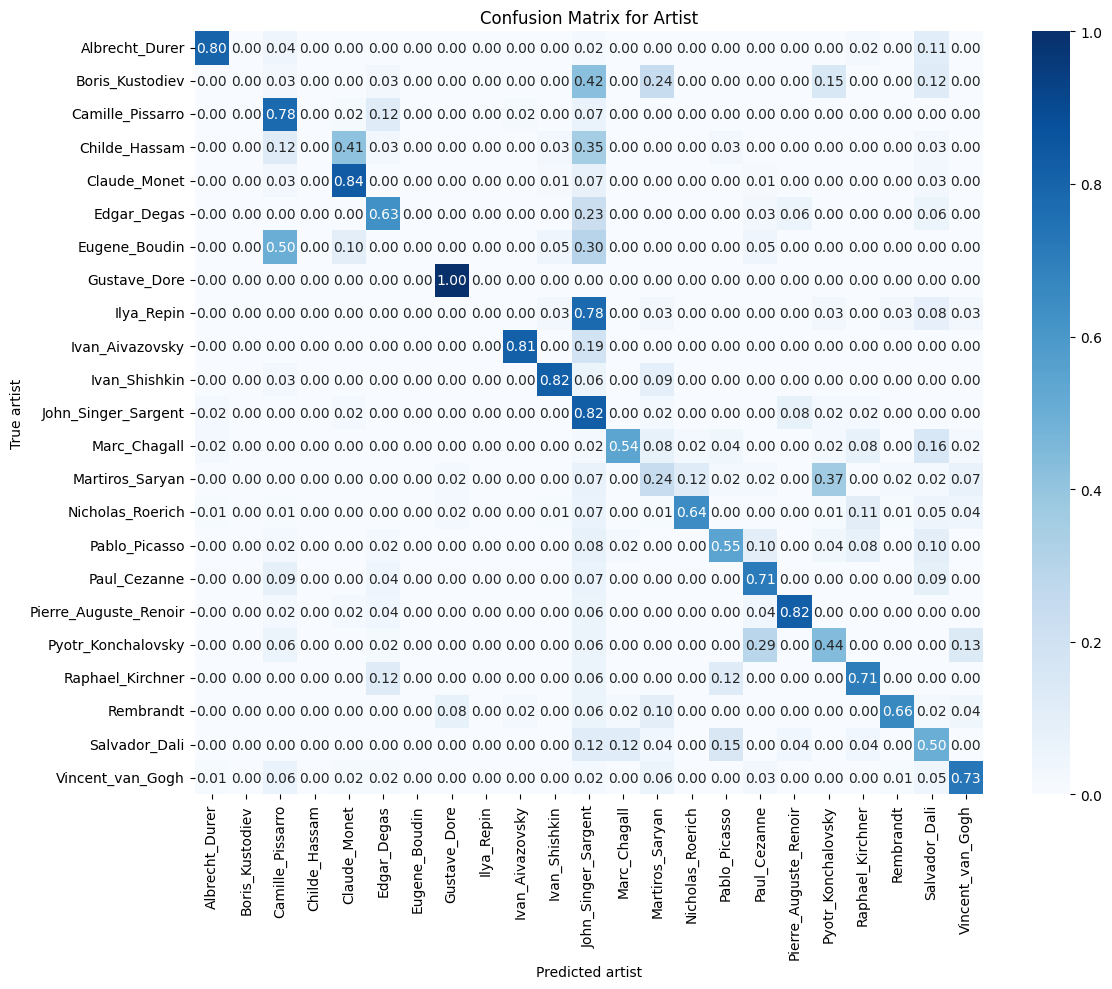

Generating confusion matrix for genre...


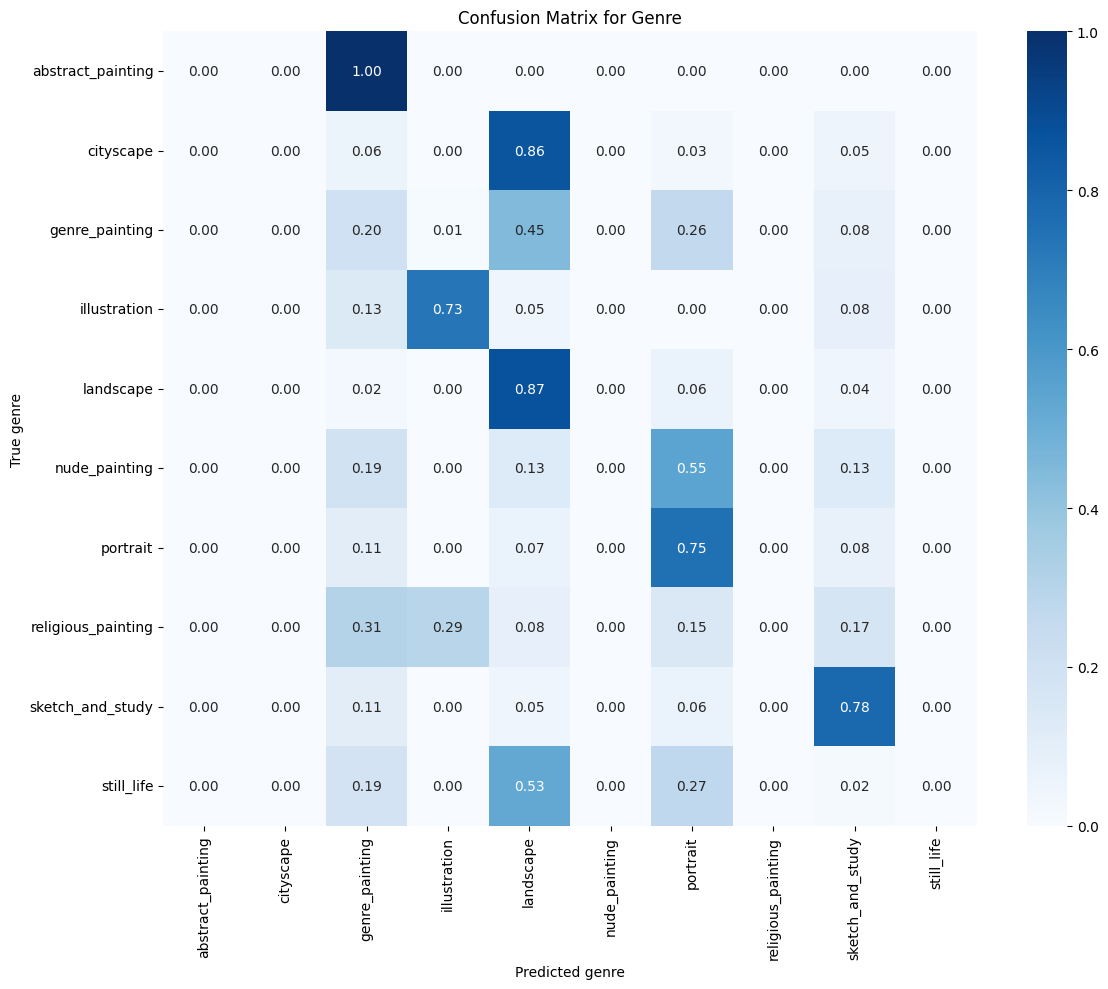

Generating confusion matrix for style...


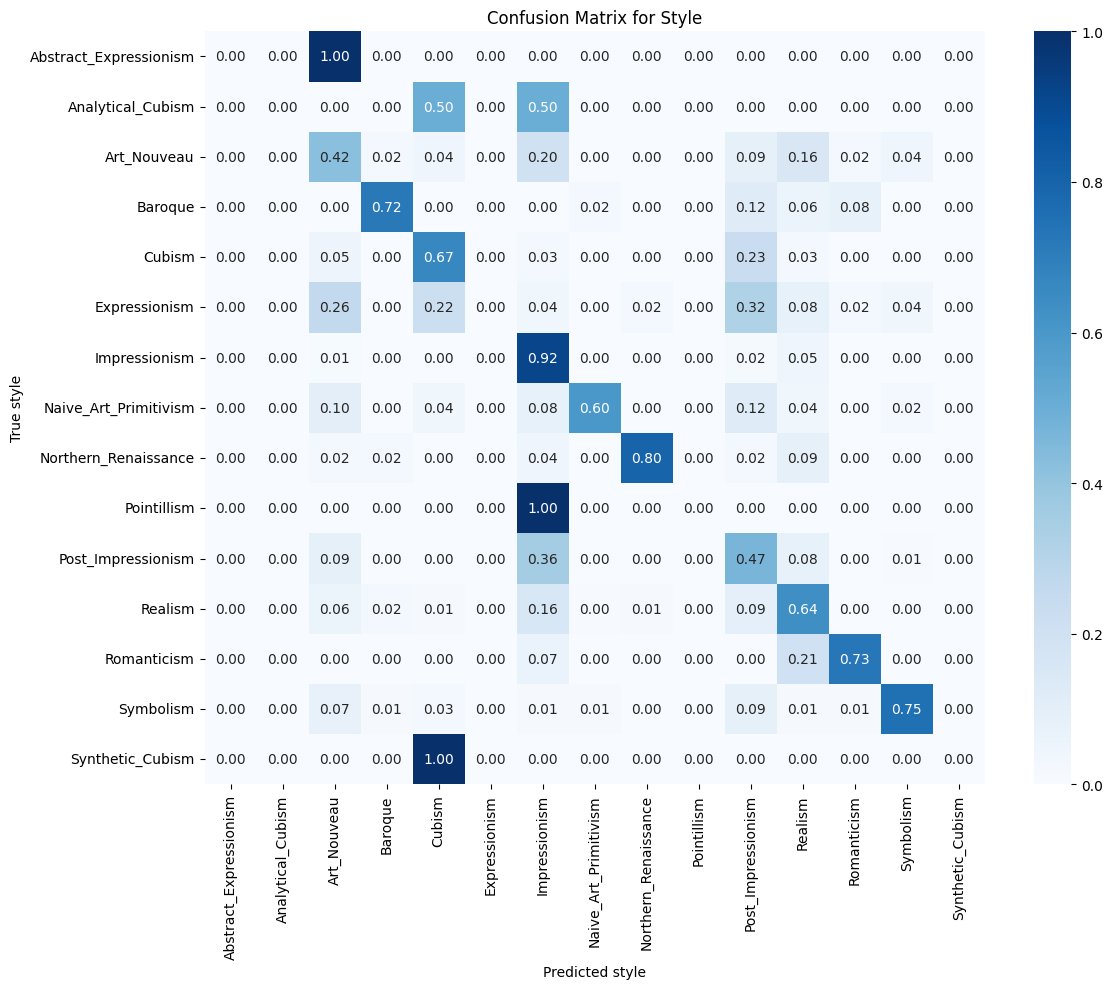

In [22]:
generate_confusion_matrices(clustering_results, artist_labels, genre_labels, style_labels, label_maps)

### Detecting outliers and their identification

In [23]:
# 4. Detect outliers for each attribute type
def detect_attribute_outliers(X, clustering_results, artist_labels, genre_labels, style_labels, contamination=0.05):
    """
    Detect outliers separately for each attribute type
    
    Parameters:
    -----------
    X : numpy array
        The embedding vectors
    clustering_results : dict
        Dictionary containing the clustering results for each attribute
    artist_labels, genre_labels, style_labels : numpy array
        The ground truth labels
    contamination : float
        The expected proportion of outliers
        
    Returns:
    --------
    outlier_results : dict
        Dictionary containing outlier detection results for each attribute
    """
    outlier_results = {}
    attribute_types = ['artist', 'genre', 'style']
    labels = [artist_labels, genre_labels, style_labels]
    
    for i, attr_type in enumerate(attribute_types):
        print(f"Detecting outliers for {attr_type}...")
        clusters = clustering_results[attr_type]['clusters']
        centers = clustering_results[attr_type]['centers']
        true_labels = labels[i]
        
        # 1. Distance-based outlier detection
        distances = np.zeros(len(X))
        for j, x in enumerate(X):
            cluster_id = clusters[j]
            center = centers[cluster_id]
            distances[j] = np.linalg.norm(x - center)
        
        # Normalize distances
        if np.max(distances) > np.min(distances):
            distance_scores = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))
        else:
            distance_scores = np.zeros_like(distances)
        
        # 2. Isolation Forest outlier detection
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        iso_predictions = iso_forest.fit_predict(X)
        iso_scores = -iso_forest.decision_function(X)
        
        # Normalize iso_scores
        if np.max(iso_scores) > np.min(iso_scores):
            iso_scores = (iso_scores - np.min(iso_scores)) / (np.max(iso_scores) - np.min(iso_scores))
        else:
            iso_scores = np.zeros_like(iso_scores)
        
        # 3. Label disagreement detection
        # Map clusters to true labels
        cluster_to_label_map, label_to_cluster_map, confusion = map_clusters_to_classes(clusters, true_labels)
        
        # Calculate consistency scores (1 - probability of true class in assigned cluster)
        consistency_scores = np.zeros(len(X))
        for j, (cluster, true_label) in enumerate(zip(clusters, true_labels)):
            if cluster in cluster_to_label_map:
                predicted_label = cluster_to_label_map[cluster]
                if predicted_label != true_label:
                    # This is a potential label inconsistency
                    consistency_scores[j] = 1.0
        
        # 4. Combine outlier scores (weighted average)
        combined_scores = (0.4 * distance_scores + 0.4 * iso_scores + 0.2 * consistency_scores)
        
        # Determine outliers
        threshold = np.percentile(combined_scores, 100 * (1 - contamination))
        outlier_mask = combined_scores > threshold
        
        # Store results
        outlier_results[attr_type] = {
            'distance_scores': distance_scores,
            'iso_scores': iso_scores,
            'consistency_scores': consistency_scores,
            'combined_scores': combined_scores,
            'outlier_mask': outlier_mask,
            'cluster_to_label_map': cluster_to_label_map,
            'label_to_cluster_map': label_to_cluster_map,
            'confusion': confusion
        }
    
    return outlier_results

In [24]:
# Detecting outliers for each attribute
outlier_results = detect_attribute_outliers(X, clustering_results, artist_labels, genre_labels, style_labels, contamination=contamination)

Detecting outliers for artist...
Detecting outliers for genre...
Detecting outliers for style...


In [25]:
# 5. Analyze outliers and create consolidated report
def analyze_attribute_outliers(X, clustering_results, outlier_results, artist_labels, genre_labels, style_labels, label_maps=None):
    """
    Analyze outliers for each attribute and create a consolidated report
    
    Parameters:
    -----------
    X : numpy array
        The embedding vectors
    clustering_results : dict
        Dictionary containing the clustering results for each attribute
    outlier_results : dict
        Dictionary containing outlier detection results for each attribute
    artist_labels, genre_labels, style_labels : numpy array
        The ground truth labels
    label_maps : dict or None
        Optional dictionary mapping from label indices to human-readable names
        
    Returns:
    --------
    outlier_df : pandas DataFrame
        DataFrame containing analysis of outliers
    """
    # Prepare data for report
    all_samples = []
    
    # Track which samples are outliers for any attribute
    combined_outlier_mask = np.zeros(len(X), dtype=bool)
    for attr_type in ['artist', 'genre', 'style']:
        combined_outlier_mask = combined_outlier_mask | outlier_results[attr_type]['outlier_mask']
    
    # Create analysis for each sample that is an outlier for at least one attribute
    for i in np.where(combined_outlier_mask)[0]:
        # Get outlier status and scores for each attribute
        is_artist_outlier = outlier_results['artist']['outlier_mask'][i]
        is_genre_outlier = outlier_results['genre']['outlier_mask'][i]
        is_style_outlier = outlier_results['style']['outlier_mask'][i]
        
        artist_score = outlier_results['artist']['combined_scores'][i]
        genre_score = outlier_results['genre']['combined_scores'][i]
        style_score = outlier_results['style']['combined_scores'][i]
        
        # Get true labels
        true_artist = artist_labels[i]
        true_genre = genre_labels[i]
        true_style = style_labels[i]
        
        # Get cluster assignments - FIXED: use clustering_results instead of outlier_results
        artist_cluster = outlier_results['artist']['cluster_to_label_map'].get(
            clustering_results['artist']['clusters'][i], None)
        genre_cluster = outlier_results['genre']['cluster_to_label_map'].get(
            clustering_results['genre']['clusters'][i], None)
        style_cluster = outlier_results['style']['cluster_to_label_map'].get(
            clustering_results['style']['clusters'][i], None)
        
        # Determine label mismatches
        artist_mismatch = artist_cluster is not None and artist_cluster != true_artist
        genre_mismatch = genre_cluster is not None and genre_cluster != true_genre
        style_mismatch = style_cluster is not None and style_cluster != true_style
        
        # Get human-readable labels if available
        if label_maps is not None:
            true_artist_name = label_maps['artist'].get(true_artist, f"Artist_{true_artist}")
            true_genre_name = label_maps['genre'].get(true_genre, f"Genre_{true_genre}")
            true_style_name = label_maps['style'].get(true_style, f"Style_{true_style}")
            
            pred_artist_name = label_maps['artist'].get(artist_cluster, f"Artist_{artist_cluster}") if artist_cluster is not None else None
            pred_genre_name = label_maps['genre'].get(genre_cluster, f"Genre_{genre_cluster}") if genre_cluster is not None else None
            pred_style_name = label_maps['style'].get(style_cluster, f"Style_{style_cluster}") if style_cluster is not None else None
        else:
            true_artist_name = f"Artist_{true_artist}"
            true_genre_name = f"Genre_{true_genre}"
            true_style_name = f"Style_{true_style}"
            
            pred_artist_name = f"Artist_{artist_cluster}" if artist_cluster is not None else None
            pred_genre_name = f"Genre_{genre_cluster}" if genre_cluster is not None else None
            pred_style_name = f"Style_{style_cluster}" if style_cluster is not None else None
        
        # Add to report
        all_samples.append({
            'index': i,
            'is_artist_outlier': is_artist_outlier,
            'is_genre_outlier': is_genre_outlier,
            'is_style_outlier': is_style_outlier,
            'artist_score': artist_score,
            'genre_score': genre_score,
            'style_score': style_score,
            'true_artist': true_artist,
            'true_genre': true_genre,
            'true_style': true_style,
            'true_artist_name': true_artist_name,
            'true_genre_name': true_genre_name,
            'true_style_name': true_style_name,
            'pred_artist': artist_cluster,
            'pred_genre': genre_cluster,
            'pred_style': style_cluster,
            'pred_artist_name': pred_artist_name,
            'pred_genre_name': pred_genre_name,
            'pred_style_name': pred_style_name,
            'artist_mismatch': artist_mismatch,
            'genre_mismatch': genre_mismatch,
            'style_mismatch': style_mismatch,
            'total_mismatches': sum([artist_mismatch, genre_mismatch, style_mismatch])
        })
    
    # Convert to DataFrame
    outlier_df = pd.DataFrame(all_samples)
    
    # Sort by number of mismatches and outlier scores
    if not outlier_df.empty:
        outlier_df['max_score'] = outlier_df[['artist_score', 'genre_score', 'style_score']].max(axis=1)
        outlier_df = outlier_df.sort_values(by=['total_mismatches', 'max_score'], ascending=False)
    
    return outlier_df

In [26]:
outlier_df = analyze_attribute_outliers(X, clustering_results, outlier_results, artist_labels, genre_labels, style_labels, label_maps)

In [27]:
outlier_df

,index,is_artist_outlier,is_genre_outlier,is_style_outlier,artist_score,genre_score,style_score,true_artist,true_genre,true_style,...,pred_genre,pred_style,pred_artist_name,pred_genre_name,pred_style_name,artist_mismatch,genre_mismatch,style_mismatch,total_mismatches,max_score
38,374,True,True,True,0.857586,0.888683,0.888650,22,9,11,...,4,2,Paul_Cezanne,landscape,Art_Nouveau,True,True,True,3,0.888683
35,344,True,True,True,0.855933,0.860612,0.874570,21,0,0,...,2,2,Marc_Chagall,genre_painting,Art_Nouveau,True,True,True,3,0.874570
72,883,True,True,True,0.863602,0.854453,0.863602,21,7,14,...,2,4,Marc_Chagall,genre_painting,Cubism,True,True,True,3,0.863602
18,237,True,True,True,0.788706,0.838486,0.848779,1,2,8,...,8,2,Martiros_Saryan,sketch_and_study,Art_Nouveau,True,True,True,3,0.848779
27,283,True,True,True,0.732858,0.821240,0.786132,1,1,12,...,2,2,Martiros_Saryan,genre_painting,Art_Nouveau,True,True,True,3,0.821240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,640,False,True,False,0.490679,0.700459,0.487879,20,4,3,...,8,3,Rembrandt,sketch_and_study,Baroque,False,True,False,1,0.700459
75,941,False,False,True,0.459172,0.499412,0.690317,13,2,5,...,2,2,Martiros_Saryan,genre_painting,Art_Nouveau,False,False,True,1,0.690317
46,528,False,False,True,0.493824,0.487269,0.680993,20,8,3,...,8,11,Rembrandt,sketch_and_study,Post_Impressionism,False,False,True,1,0.680993
89,1092,False,False,True,0.272495,0.459698,0.676826,22,4,11,...,4,7,Vincent_van_Gogh,landscape,Impressionism,False,False,True,1,0.676826


### Visualisation of clusters and outliers using SNE Projection

In [28]:
# 6. Visualize results for each attribute
def visualize_attribute_results(X, clustering_results, outlier_results, artist_labels, genre_labels, style_labels):
    """
    Create visualizations for each attribute's clustering and outlier detection
    
    Parameters:
    -----------
    X : numpy array
        The embedding vectors
    clustering_results : dict
        Dictionary containing the clustering results for each attribute
    outlier_results : dict
        Dictionary containing outlier detection results for each attribute
    artist_labels, genre_labels, style_labels : numpy array
        The ground truth labels
    """
    # Use t-SNE for dimensionality reduction
    print("Computing t-SNE projection...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, learning_rate='auto', init='pca')
    X_2d = tsne.fit_transform(X)
    
    # Visualization for each attribute
    attribute_types = ['artist', 'genre', 'style']
    labels = [artist_labels, genre_labels, style_labels]
    num_classes = [23, 10, 16]  # Known number of classes
    
    for i, attr_type in enumerate(attribute_types):
        print(f"Creating visualizations for {attr_type}...")
        
        # Create a figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Get data for this attribute
        clusters = clustering_results[attr_type]['clusters']
        true_labels = labels[i]
        outlier_mask = outlier_results[attr_type]['outlier_mask']
        outlier_scores = outlier_results[attr_type]['combined_scores']
        
        # Plot 1: K-means clusters
        scatter1 = axes[0, 0].scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='tab20', alpha=0.7)
        axes[0, 0].set_title(f"t-SNE: {attr_type.capitalize()} K-means Clusters (k={num_classes[i]})")
        fig.colorbar(scatter1, ax=axes[0, 0])
        
        # Plot 2: True labels
        scatter2 = axes[0, 1].scatter(X_2d[:, 0], X_2d[:, 1], c=true_labels, cmap='tab20', alpha=0.7)
        axes[0, 1].set_title(f"t-SNE: True {attr_type.capitalize()} Labels")
        fig.colorbar(scatter2, ax=axes[0, 1])
        
        # Plot 3: Outliers
        inlier_mask = ~outlier_mask
        axes[1, 0].scatter(X_2d[inlier_mask, 0], X_2d[inlier_mask, 1], 
                         c=clusters[inlier_mask], cmap='tab20', alpha=0.5, label='Inliers')
        axes[1, 0].scatter(X_2d[outlier_mask, 0], X_2d[outlier_mask, 1], 
                         c='red', marker='x', s=100, alpha=1.0, label='Outliers')
        axes[1, 0].set_title(f"t-SNE: {attr_type.capitalize()} Outliers")
        axes[1, 0].legend()
        
        # Plot 4: Confusion between clusters and true labels
        confusion = outlier_results[attr_type]['confusion']
        cax = axes[1, 1].imshow(confusion, cmap='Blues', interpolation='nearest')
        axes[1, 1].set_title(f"Cluster-to-{attr_type.capitalize()} Confusion Matrix")
        axes[1, 1].set_xlabel("Cluster ID")
        axes[1, 1].set_ylabel(f"True {attr_type.capitalize()} Label")
        fig.colorbar(cax, ax=axes[1, 1])
        
        plt.tight_layout()
        plt.savefig(f"{attr_type}_analysis.png")
        plt.show()

    # Create combined outlier visualization
    combined_outlier_mask = np.zeros(len(X), dtype=bool)
    for attr_type in attribute_types:
        combined_outlier_mask = combined_outlier_mask | outlier_results[attr_type]['outlier_mask']

    plt.figure(figsize=(10, 8))
    # Plot normal samples
    plt.scatter(X_2d[~combined_outlier_mask, 0], X_2d[~combined_outlier_mask, 1], 
           c='blue', alpha=0.5, label='Normal Samples')

    # Plot each outlier type separately so they'll appear in the legend
    artist_only = np.zeros(len(X), dtype=bool)
    genre_only = np.zeros(len(X), dtype=bool)
    style_only = np.zeros(len(X), dtype=bool)
    two_attrs = np.zeros(len(X), dtype=bool)
    three_attrs = np.zeros(len(X), dtype=bool)

    # Color outliers by which attribute(s) they're outliers for
    for i in np.where(combined_outlier_mask)[0]:
        outlier_count = 0
        if outlier_results['artist']['outlier_mask'][i]: 
            outlier_count += 1
        if outlier_results['genre']['outlier_mask'][i]: 
            outlier_count += 1
        if outlier_results['style']['outlier_mask'][i]: 
            outlier_count += 1
            
        if outlier_count == 1:
            if outlier_results['artist']['outlier_mask'][i]: 
                artist_only[i] = True
            
            elif outlier_results['genre']['outlier_mask'][i]: 
                genre_only[i] = True
                
            elif outlier_results['style']['outlier_mask'][i]: 
                style_only[i] = True
            
        elif outlier_count == 2:
            two_attrs[i] = True
        
        else:  # All three
            three_attrs[i] = True

    # Now plot each category with a label
    if np.any(artist_only):
        plt.scatter(X_2d[artist_only, 0], X_2d[artist_only, 1], 
                    c='red', marker='x', s=100, alpha=0.8, label='Artist Outliers')
    
    if np.any(genre_only):
        plt.scatter(X_2d[genre_only, 0], X_2d[genre_only, 1], 
                    c='green', marker='x', s=100, alpha=0.8, label='Genre Outliers')
               
    if np.any(style_only):
        plt.scatter(X_2d[style_only, 0], X_2d[style_only, 1], 
                    c='purple', marker='x', s=100, alpha=0.8, label='Style Outliers')
               
    if np.any(two_attrs):
        plt.scatter(X_2d[two_attrs, 0], X_2d[two_attrs, 1], 
                    c='orange', marker='x', s=100, alpha=0.8, label='Two-attribute Outliers')
               
    if np.any(three_attrs):
        plt.scatter(X_2d[three_attrs, 0], X_2d[three_attrs, 1], 
                    c='black', marker='x', s=100, alpha=0.8, label='Three-attribute Outliers')

    # Add legend, now it will show the actual plotted points
    plt.legend()
    plt.title("t-SNE: Combined Outlier Analysis")
    plt.savefig("combined_outliers.png")
    plt.show()

Computing t-SNE projection...
Creating visualizations for artist...


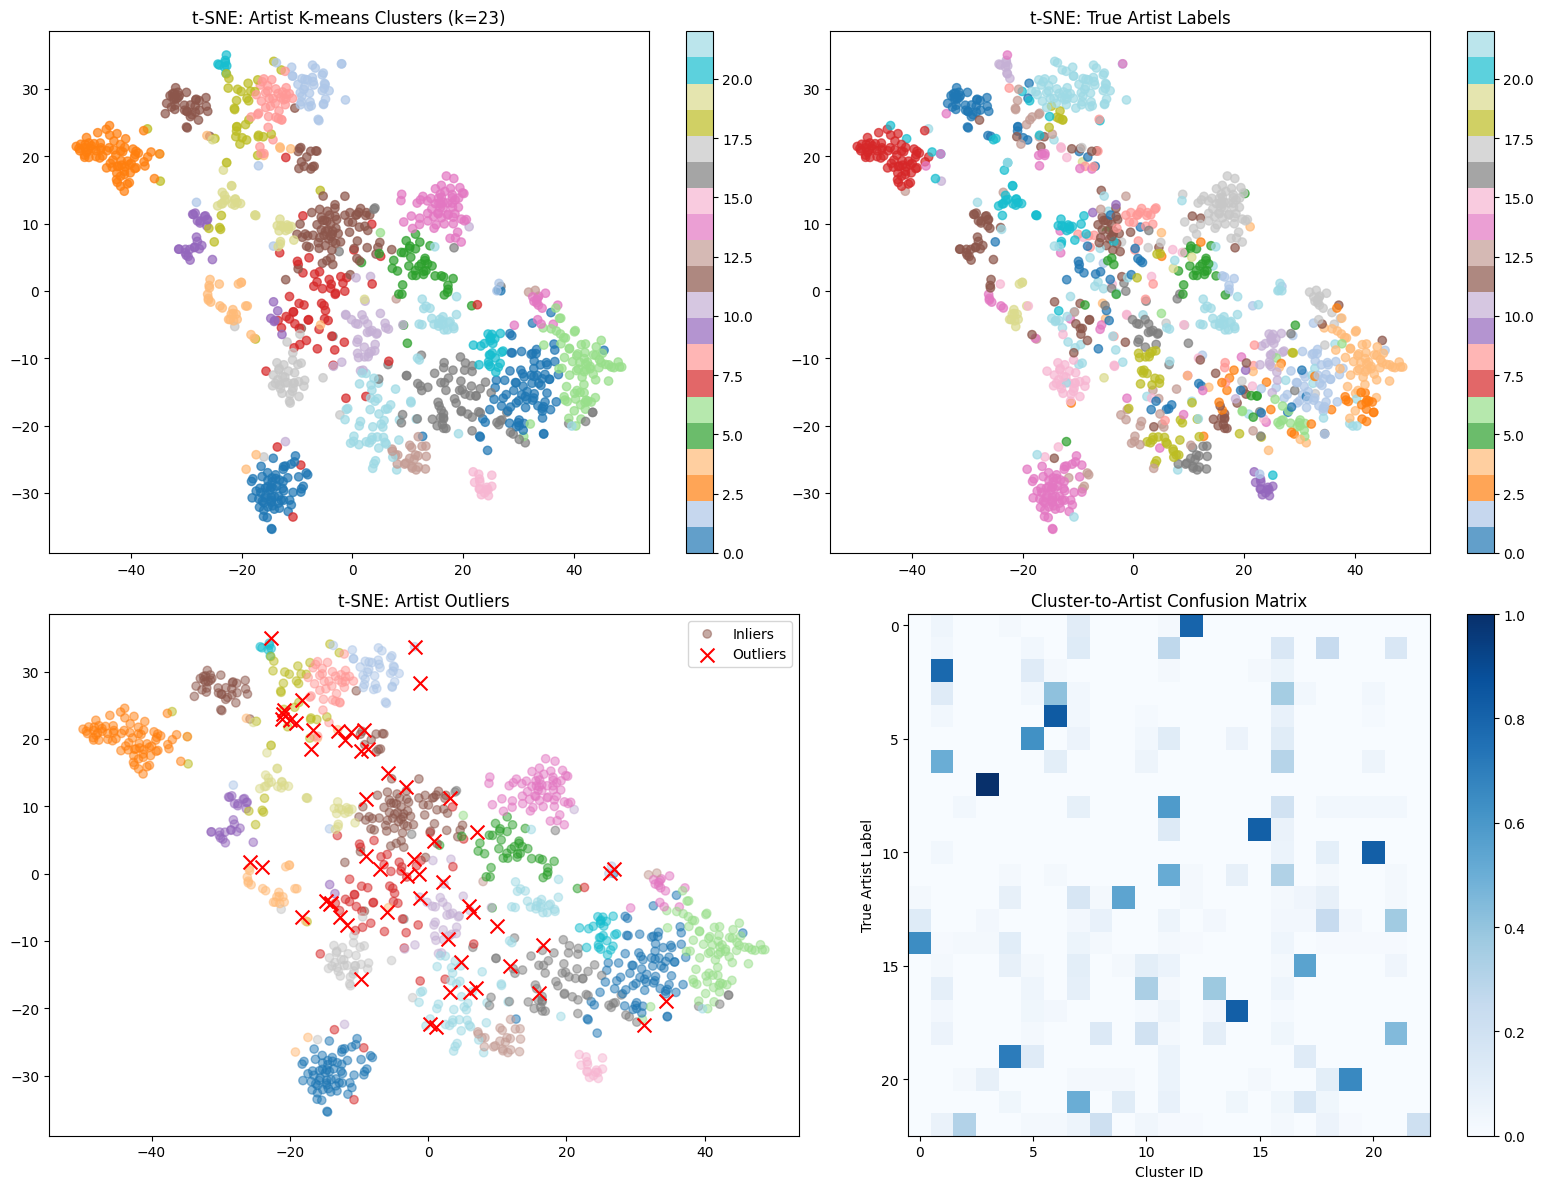

Creating visualizations for genre...


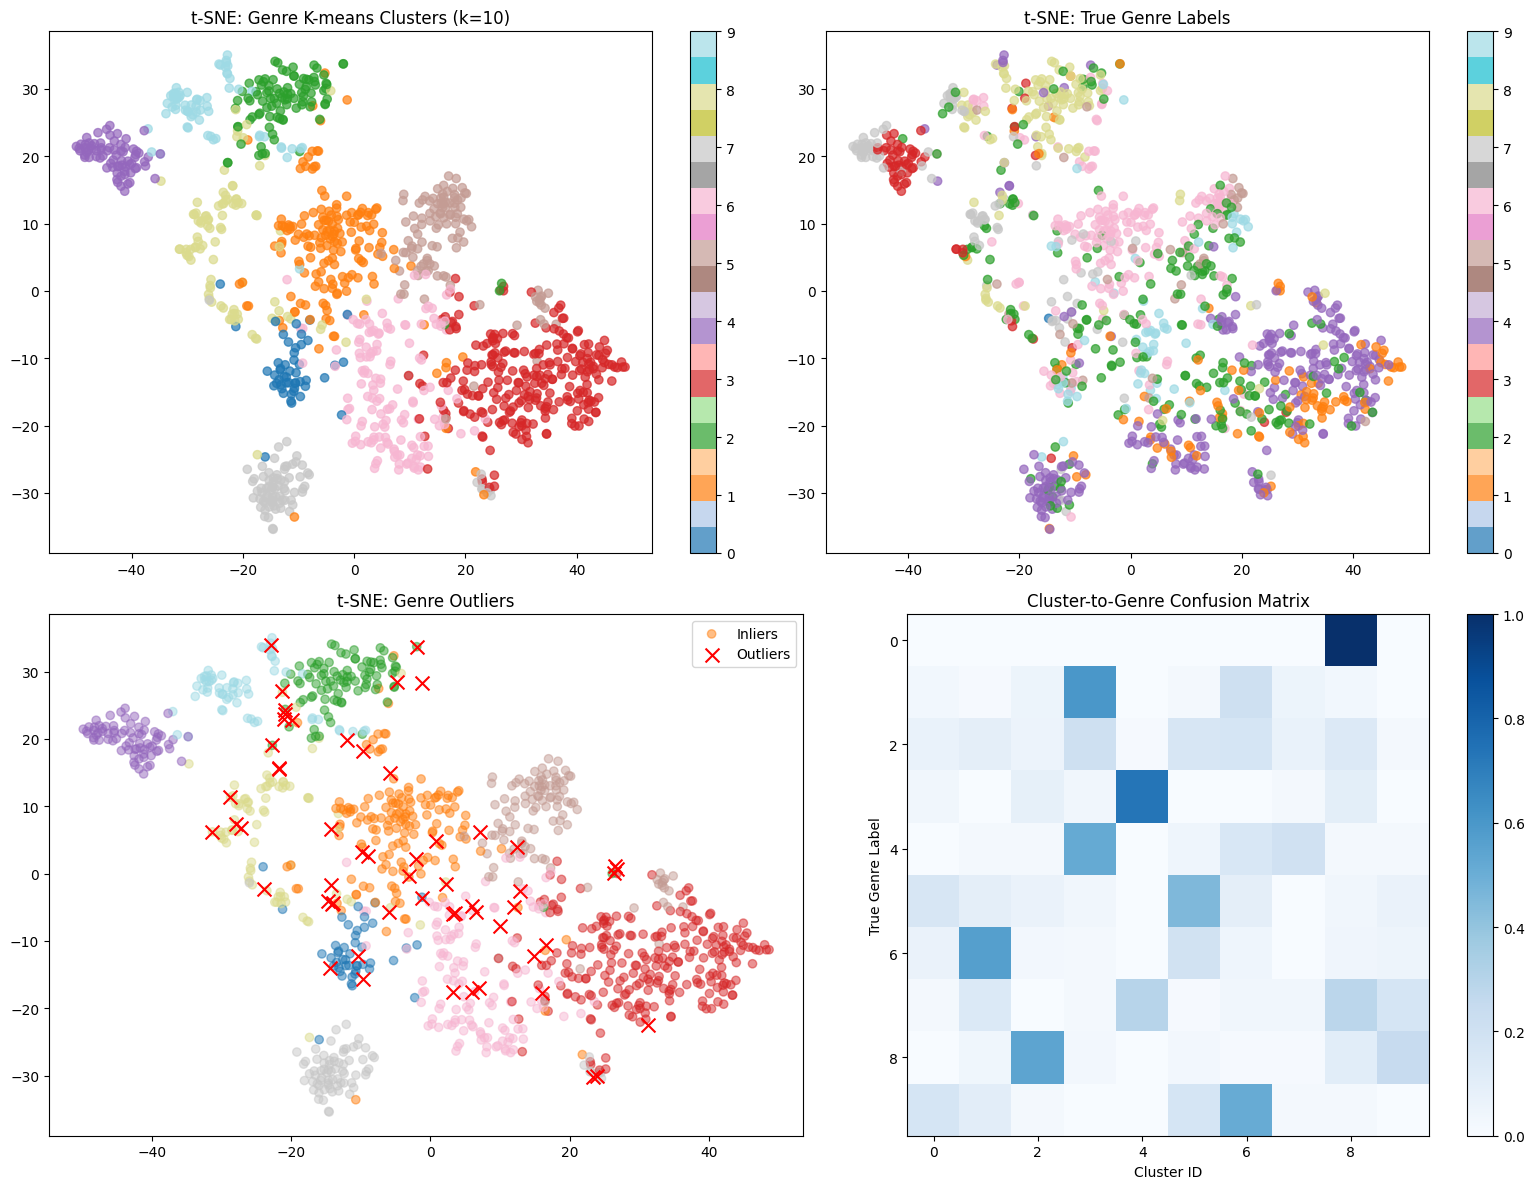

Creating visualizations for style...


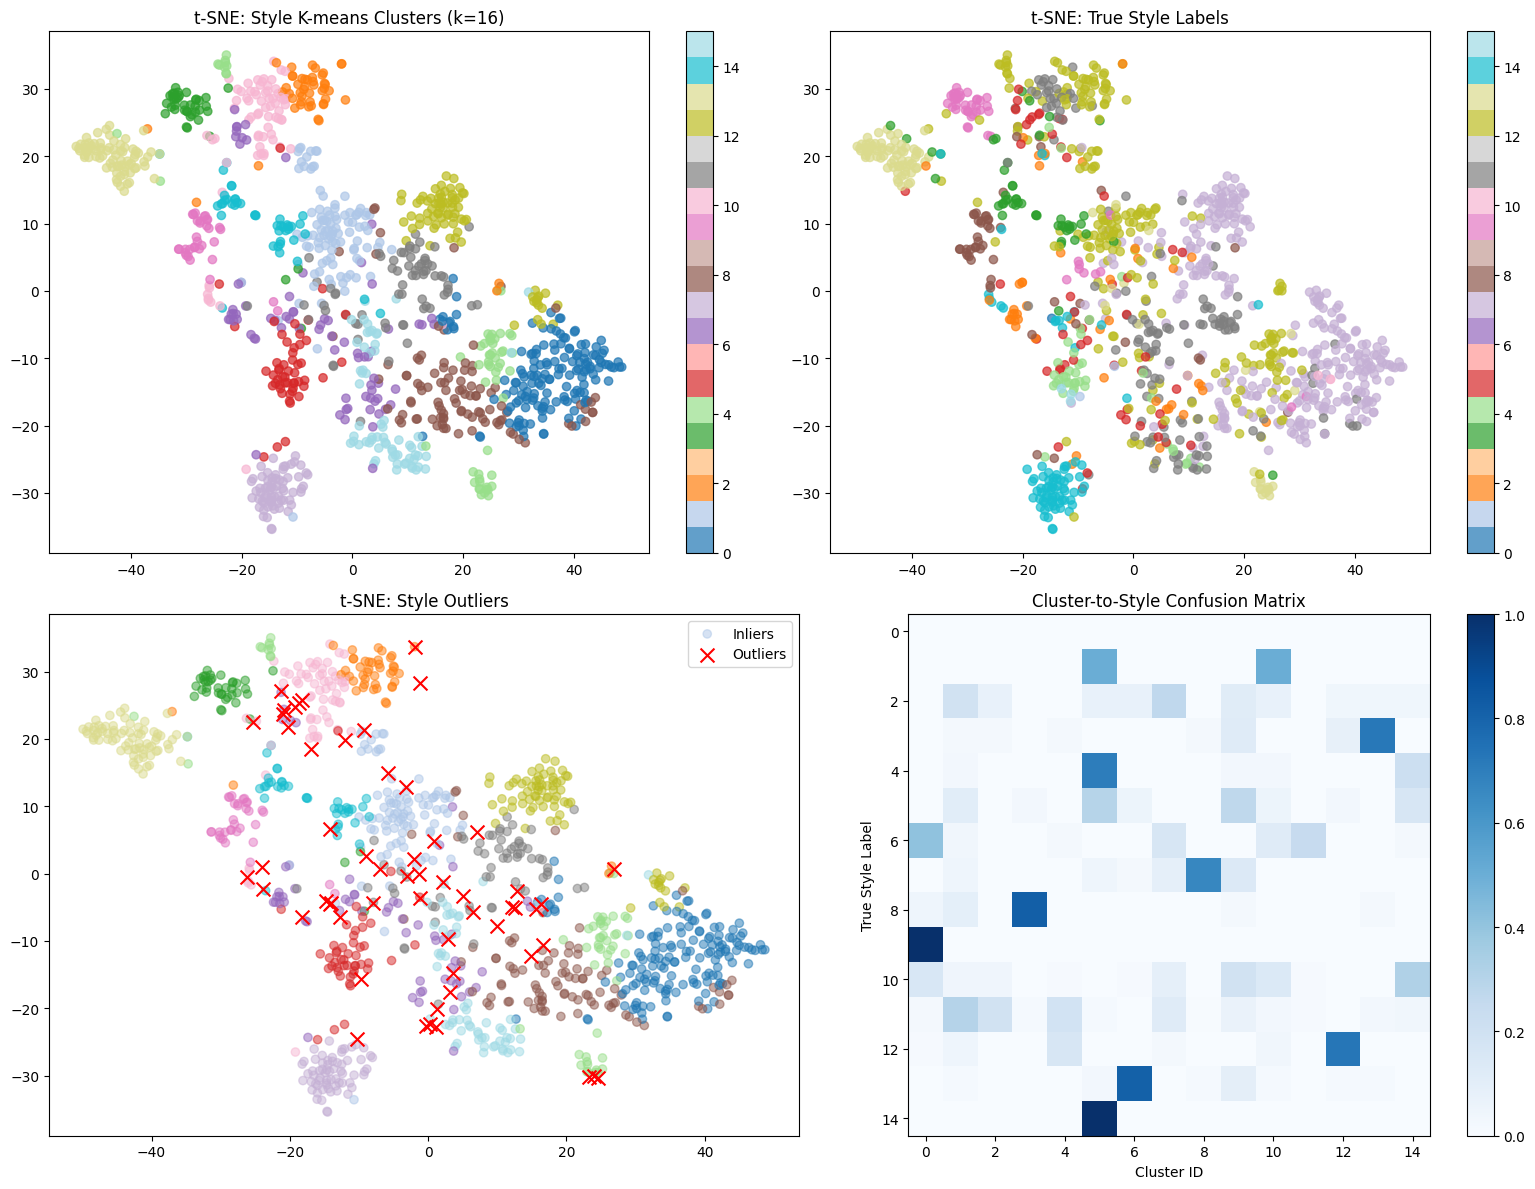

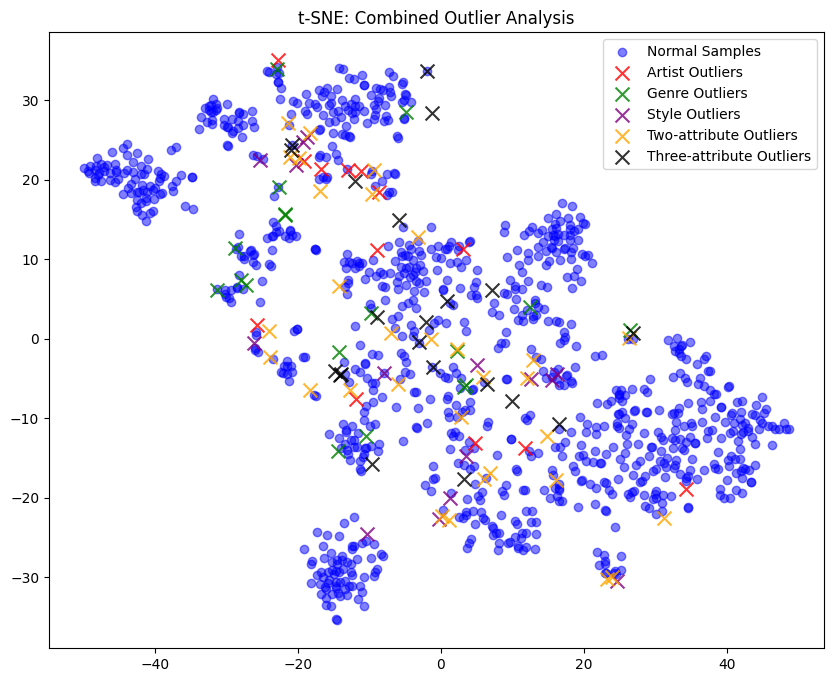

In [29]:
visualize_attribute_results(X, clustering_results, outlier_results, artist_labels, genre_labels, style_labels)

### Summary

In [30]:
# Print summary of potentially mislabeled samples
print("Summary of outlier detection:")
print(f"Total number of samples: {len(X)}")
    
for attr_type in ['artist', 'genre', 'style']:
    num_outliers = np.sum(outlier_results[attr_type]['outlier_mask'])
    print(f"{attr_type.capitalize()} outliers: {num_outliers} ({num_outliers/len(X)*100:.2f}% of data)")
    
combined_outlier_mask = np.zeros(len(X), dtype=bool)
for attr_type in ['artist', 'genre', 'style']:
    combined_outlier_mask = combined_outlier_mask | outlier_results[attr_type]['outlier_mask']
    
num_combined_outliers = np.sum(combined_outlier_mask)
print(f"Combined outliers (any attribute): {num_combined_outliers} ({num_combined_outliers/len(X)*100:.2f}% of data)")

Summary of outlier detection:
Total number of samples: 1128
Artist outliers: 57 (5.05% of data)
Genre outliers: 57 (5.05% of data)
Style outliers: 57 (5.05% of data)
Combined outliers (any attribute): 98 (8.69% of data)


### Top outliers Image visualisation

In [31]:
def visualize_top_outliers(test_loader, outlier_df, num_examples=5, output_dir='.'):
    """
    Visualize the top outliers identified by multi_attribute_outlier_detection
    and save the visualizations to disk.
    
    Parameters:
    -----------
    test_loader : torch.utils.data.DataLoader
        DataLoader for the test dataset
    outlier_df : pandas DataFrame
        DataFrame containing analysis of outliers, as returned by multi_attribute_outlier_detection
    num_examples : int
        Number of top examples to visualize
    output_dir : str
        Directory to save the visualization images
    
    Returns:
    --------
    saved_paths : list
        List of file paths where visualizations were saved
    """
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # First, extract all severe mismatches and calculate combined score
    severe_mismatches = outlier_df[outlier_df['total_mismatches'] == 3].copy()
    if severe_mismatches.empty:
        print("No severe mismatches (all three attributes) found in the data.")
        return []
    
    # Calculate combined outlier score for ranking
    severe_mismatches['combined_score'] = (
        severe_mismatches['artist_score'] + 
        severe_mismatches['genre_score'] + 
        severe_mismatches['style_score']
    )
    
    # Sort by combined score in descending order and get top examples
    top_outliers = severe_mismatches.sort_values(
        by='combined_score', ascending=False
    ).head(num_examples)
    
    # Get the sample indices of the top outliers
    sample_indices = top_outliers['index'].values
    
    # Create a dictionary to map from sample index to image
    index_to_image = {}
    
    # Extract images from test_loader based on sample indices
    print("Extracting images from test_loader...")
    all_data = []
    all_indices = []
    
    # First pass: collect all data and their indices
    for i, batch in enumerate(test_loader):
        # Assumes test_loader returns (images, (artist_labels, genre_labels, style_labels))
        images, targets = batch
        
        # Generate sequential indices if not provided
        if len(batch) > 2:  # If indices are provided as a separate item
            batch_indices = batch[-1]
        else:
            # Generate sequential indices based on batch size and position
            batch_size = images.shape[0]
            start_idx = i * batch_size
            batch_indices = torch.arange(start_idx, start_idx + batch_size)
        
        # Store images and indices
        all_data.append(images)
        all_indices.append(batch_indices)
    
    # Concatenate all data and indices
    all_data = torch.cat(all_data, dim=0)
    all_indices = torch.cat(all_indices, dim=0)
    
    # Find the images corresponding to our sample indices
    for sample_idx in sample_indices:
        # Find the position of this sample in the dataset
        positions = (all_indices == sample_idx).nonzero(as_tuple=True)[0]
        if len(positions) > 0:
            pos = positions[0].item()
            # Get the image
            index_to_image[sample_idx] = all_data[pos]
    
    # Check if we found all images
    missing_indices = set(sample_indices) - set(index_to_image.keys())
    if missing_indices:
        print(f"Warning: Could not find images for samples: {missing_indices}")
    
    # Save visualizations for the top outliers
    saved_paths = []
    
    for idx, (_, row) in enumerate(top_outliers.iterrows(), 1):
        sample_idx = row['index']
        if sample_idx not in index_to_image:
            continue
        
        # Get the image
        image = index_to_image[sample_idx].cpu().numpy()
        
        # Convert image from CHW to HWC format for plotting if needed
        if image.shape[0] == 3:  # Check if it's in CHW format
            image = np.transpose(image, (1, 2, 0))
        
        # De-normalize the image 
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        # Create visualization
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.axis('off')
        
        # Add title with sample info
        title = f"Sample #{sample_idx} - Top Outlier #{idx}"
        plt.title(title, fontsize=14)
        
        # Add text with outlier information
        text_info = [
            f"True labels: Artist={row['true_artist_name']}, Genre={row['true_genre_name']}, Style={row['true_style_name']}",
            f"Predicted: Artist={row['pred_artist_name']}, Genre={row['pred_genre_name']}, Style={row['pred_style_name']}",
            f"Outlier scores: Artist={row['artist_score']:.3f}, Genre={row['genre_score']:.3f}, Style={row['style_score']:.3f}"
        ]
        
        plt.figtext(0.5, 0.01, '\n'.join(text_info), ha='center', fontsize=12, 
                   bbox=dict(facecolor='white', alpha=0.8))
        
        # Save the visualization to disk
        output_path = os.path.join(output_dir, f"outlier_{idx}_sample_{sample_idx}.png")
        plt.savefig(output_path, bbox_inches='tight', dpi=150)
        plt.close()
        
        saved_paths.append(output_path)
        
        # Print information about the visualization
        print(f"Visualization for Sample #{sample_idx}:")
        print(f"  Saved to: {output_path}")
        print()
    
    # Print summary
    if saved_paths:
        print(f"Successfully saved {len(saved_paths)} visualizations to directory: {os.path.abspath(output_dir)}")
    else:
        print("No visualizations were created.")
    
    return saved_paths

In [32]:
# Create a specific output directory for the visualizations
output_directory = "outlier_visualizations"

# Visualize the top 5 outliers without modifying your existing code
saved_paths = visualize_top_outliers(test_loader, outlier_df, num_examples=5, output_dir=output_directory)

Extracting images from test_loader...
Visualization for Sample #374:
  Saved to: outlier_visualizations/outlier_1_sample_374.png

Visualization for Sample #344:
  Saved to: outlier_visualizations/outlier_2_sample_344.png

Visualization for Sample #883:
  Saved to: outlier_visualizations/outlier_3_sample_883.png

Visualization for Sample #237:
  Saved to: outlier_visualizations/outlier_4_sample_237.png

Visualization for Sample #283:
  Saved to: outlier_visualizations/outlier_5_sample_283.png

Successfully saved 5 visualizations to directory: /kaggle/working/outlier_visualizations


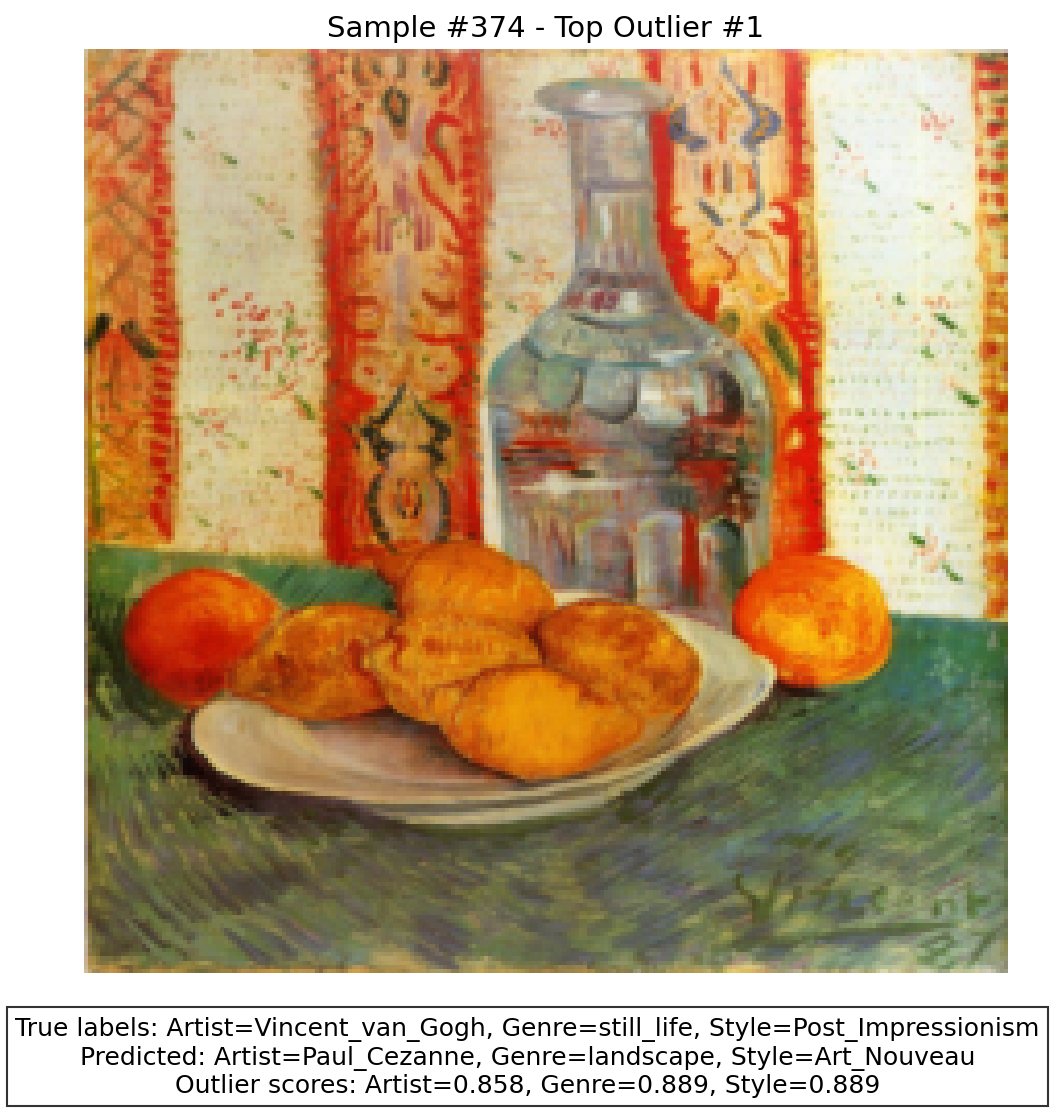

In [33]:
Image.open(saved_paths[0])

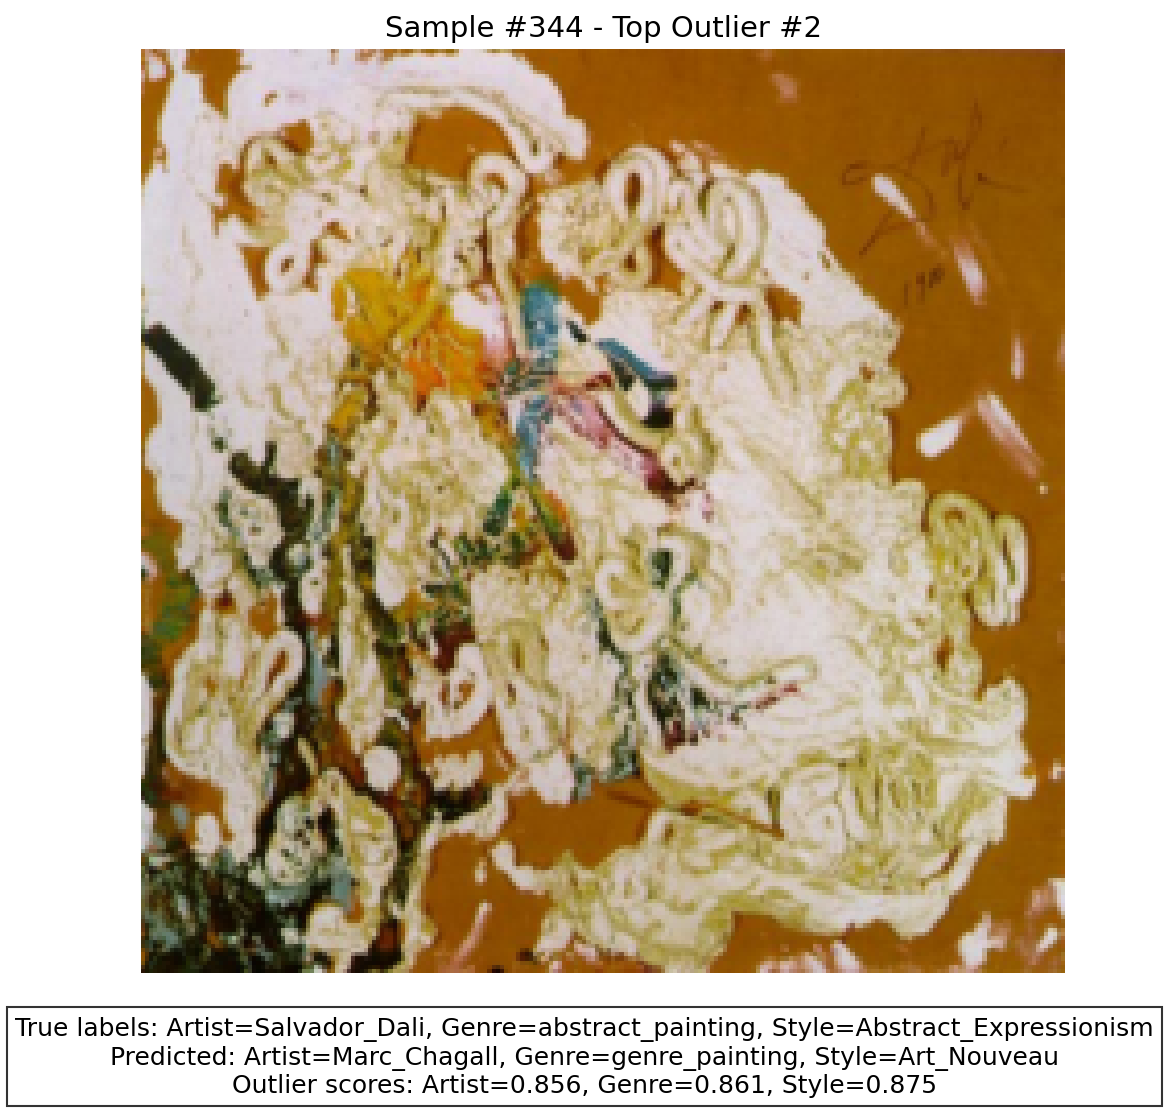

In [34]:
Image.open(saved_paths[1])

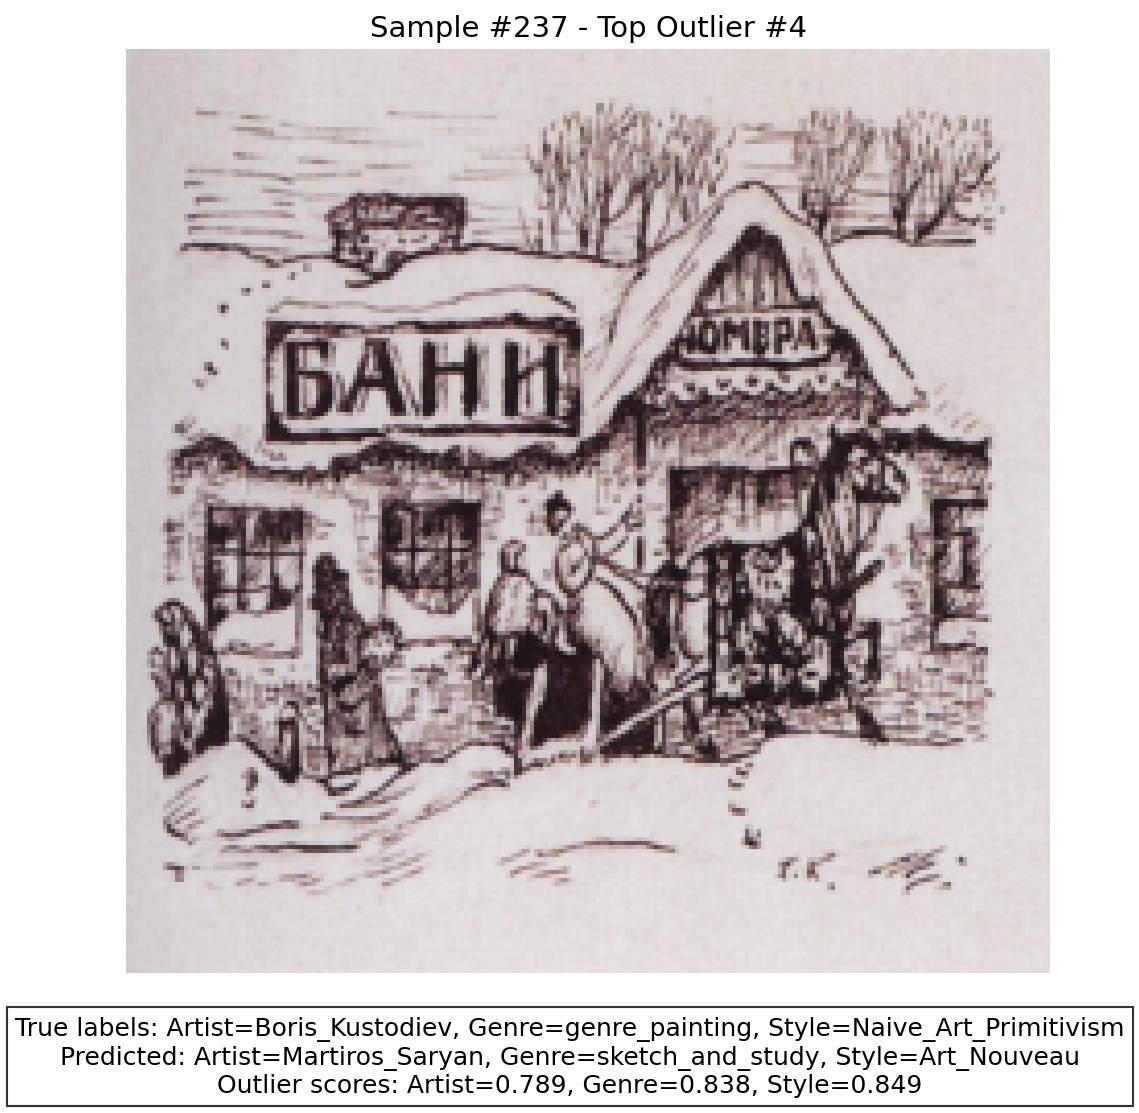

In [35]:
Image.open(saved_paths[3])